In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import pairwise_distances
%matplotlib inline

# KNN - *K*-nearest neighbors (*K* vizinhos mais próximos)

Até agora estudamos apenas o classificador baseado em limiar. Embora seja simples de implementar, este classificador tem sérias limitações. A principal delas é que ele assume que as classes podem ser separadas linearmente por um único atributo. 

Hoje vamos estudar um classificador amplamente utilizado que é capaz de considerar multiplos atributos. O algoritmo *KNN* (também abreviado como *k-NN*) assume que instâncias com características "parecidas" provavelmente pertencem a mesma classe. Para que a classificação baseada em semelhança possa ser automatizada, é necessário definir alguma métrica de similaridade que indica o quão semelhante (ou diferente) é um dado par de instâncias. Uma métrica comumente utilizada para computar a diferença entre dois **vetores de atributos** é a **distância euclidiana**. Seja $p \in \mathbb{R}^n$ e $q \in \mathbb{R}^n$ dois pontos no espaço n-dimensional (duas instâncias com $n$ atributos). A distância euclidiana $\text{dist}(p,q)$ entre $p$ e $q$ é dada por: 

$$
\text{dist}(p,q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
$$

Note que a distância euclidiana é uma generalização do teorema de pitágoras para n-dimensões onde um dos pontos é deslocado para a origem. A semelhança nos pontos pode ser interpretada como inversamente proporcional a distância. Ou seja, quanto mais próxima de $0$ for a distância mais semelhante é um par de vetores de atributos. Note que a distância euclidiana (como qualquer outra métrica de distância) é sempre positiva.

Com uma medida de distância podemos realizar a classificação de uma nova instância $x$ encontrando o ponto mais próximo que pertence ao conjunto de treinamento. Como o rótulo de todos os pontos do conjunto de treinamento são conhecidos, atribuímos o rótulo do ponto mais próximo (também chamado de **vizinho mais próximo**) ao ponto $x$. Entretanto, temos que considerar a existência de pontos aberrantes (**outliers**), no conjunto de treinamento. Para diminuir a influência desse possível ruído são encontrados os $k$ vizinhos mais próximos de $x$. O rótulo de $x$ é então decidido considerando a rótulo da maioria dos de seus $k$ vizinhos mais próximos.

In [29]:
class KNN(object):
    def __init__(self, k):
        self.k = k
        self.pontos = None
        self.rotulos = None
        
    def fit(self, X, y):
        self.pontos = X
        self.rotulos = y
        
    @staticmethod
    def dist(p,q):
        return np.sqrt(np.sum((p-q)**2))    
    
    def predict(self, X):
        predicoes = []
        # para cada instância p de X
        for p in X:
            # calcular a distância de p para todos os pontos do conjunto de treinamento
            #d = [self.dist(p,q) for q in self.pontos]
            d = pairwise_distances(self.pontos, p.reshape((1,-1))).flatten()
            # retornar os índices em ordem crescente de distância
            ds = np.argsort(d)
            # pegar apenas os índices dos k-vizinhos mais próximos
            knn = ds[:self.k]
            # pegar os rótulos dos k-vizinhos mais próximos
            rotulos = self.rotulos[knn]
            # contar os rótulos dos vizinhos mais próximos
            rotulos, cont = np.unique(rotulos, return_counts=True)
            # a predição do ponto p é o rótulo majoritário
            pred = rotulos[np.argmax(cont)]
            predicoes.append(pred)
        return np.array(predicoes)
            

# KNN em um subconjunto dos atributos da base *iris*

In [26]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [45]:
def obter_atributos(ds, atributos):
    # vamos usar somente as medidas das sépalas para 
    # facilitar a visualização (poderíamos usar PCA também)
    df = ds.frame[[*atributos, 'target']]
    X = df[atributos]
    y = df['target']
    
    return df, X, y

ds = load_iris(as_frame=True)

atributos = ['sepal length (cm)', 'sepal width (cm)']

df, X, y = obter_atributos(ds, atributos)

# X.values e y.values para extrai os dados como numpy arrays, 
# que são esperados pela nossa implementação de KNN
X_treino, X_teste, y_treino, y_teste = train_test_split(
        X.values, y.values, test_size=0.2, random_state=1,
        stratify=y.values)

knn = KNN(k=1)
# treinar o classificador. No caso da nossa implementação, 
# apenas salvar os pontos de treino e seus rótulos.
knn.fit(X_treino, y_treino)   
# classificar as instâncias do conjunto de teste.
pred = knn.predict(X_teste)   

print("Acurácia no teste: %.2f" % accuracy_score(y_teste, pred))

Acurácia no teste: 0.70


A acurácia obtida foi tímida, principalmente considerando que este dataset é conhecidamente fácil. Vamos visualizar o espaço de características para verificar se as características escolhidas contém informação suficiente para fazer a classificação.

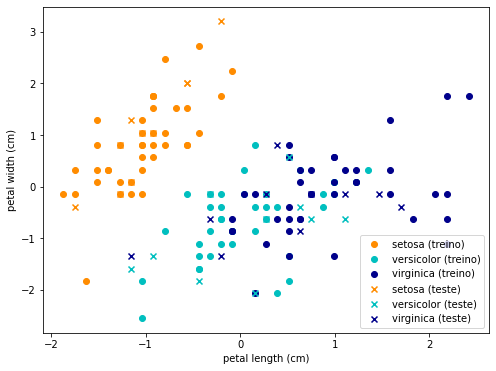

In [44]:
def plotar_instancias(X_treino, y_treino, X_teste, y_teste, cmap=None, ax=None):
    if cmap is None:
        cmap = ['darkorange', 'c', 'darkblue']
    if ax is None:
        _, ax = plt.subplots(figsize=(8,6))
    ax.scatter(X_treino[y_treino==0,0], X_treino[y_treino==0,1], 
               c=cmap[0], label='setosa (treino)')
    ax.scatter(X_treino[y_treino==1,0], X_treino[y_treino==1,1], 
               c=cmap[1], label='versicolor (treino)')
    ax.scatter(X_treino[y_treino==2,0], X_treino[y_treino==2,1], 
               c=cmap[2], label='virginica (treino)')

    ax.scatter(X_teste[y_teste==0,0], X_teste[y_teste==0,1], 
               c=cmap[0], marker='x', label='setosa (teste)')
    ax.scatter(X_teste[y_teste==1,0], X_teste[y_teste==1,1], 
               c=cmap[1], marker='x', label='versicolor (teste)')
    ax.scatter(X_teste[y_teste==2,0], X_teste[y_teste==2,1], 
               c=cmap[2], marker='x', label='virginica (teste)')
    ax.legend(loc='best')
    
    return ax
    
ax = plotar_instancias(X_treino, y_treino, X_teste, y_teste)
ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])
plt.show()

O gráfico acima mostra que há certa confusão entre versicolor e virginica. Entretanto, a **fronteira de decisão** do classificador knn não é muito óbvia olhando apenas as instâncias no espaço. A fronteira de decisão é a demarcação das regiões do espaço que caracterizam cada classe. Para ter uma idéia melhor, vamos fazer um gráfico da fronteira de decisão usando um *contour plot*. 

Plotar a fronteira de decisão envolve realizar a classificação de muitos pontos no espaço. Embora nossa implementação do KNN esteja correta, ela não é otimizada. Portanto, ela vai demorar muito para computar todos os pontos no espaço que são necessários para visualizar a fronteira de decisão.

Existem muitas formas de acelerar o KNN. Uma delas é usar uma estrutura de dados auxiliar para acelerar a pesquisa pelos vizinhos mais próximos sem ter que calcular a distância entre todos os pontos toda vez. Entretanto, esta implementação mais eficiente está fora do escopo do nosso estudo. Portanto, vamos usar a implementação do sklearn.

In [33]:
# timeit é uma função que faz algumas medidas de tempo 
# para facilitar a comparação dos tempos de execução de algoritmos
# abaixo vemos o tempo que a nossa implementação do KNN 
# demora para executar a função de classificação
#%timeit pred = knn.predict(X_teste)

4.69 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
# esta é a classe que implementa o KNN no sklearn
from sklearn.neighbors import KNeighborsClassifier  

knn = KNeighborsClassifier(n_neighbors=1)
# treinar o knn. nesta implementação uma árvore de 
# distâncias é usada para acelerar a busca por vizinhos mais próximos.
knn.fit(X_treino, y_treino)
# classificar os exemplos do conjunto de teste.
pred = knn.predict(X_teste) 

In [35]:
# note como a implementação do sklearn é praticamente 
# 3x mais rápida que a nossa!
#%timeit pred = knn.predict(X_teste)

1.25 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Fronteira de decisão

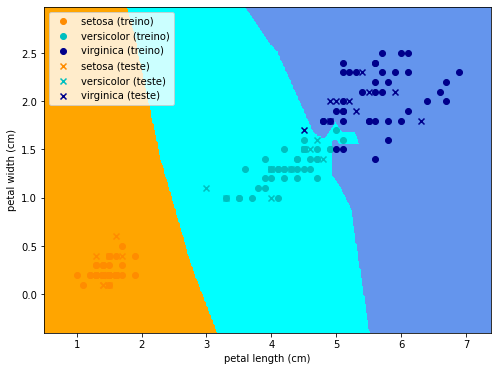

In [38]:
from matplotlib.colors import ListedColormap

def plotar_fronteira_decisao(classificador, X_treino, y_treino, X_teste, y_teste, ax=None):

    #criar um mapa de cores de forma que a fronteira de decisão seja clara
    #e os pontos das classes correspondentes sejam da mesma cor, mas mais escuros.
    cmap_claro = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_escuro = ['darkorange', 'c', 'darkblue']

    #passo do grid de predições. Quanto menor, melhor a resolução, mas mais demorado pra calcular.
    grafico_delta = 0.02 
    
    #Criar o grid de predições. Pra prática estamos criando pontos no 
    # espaço de atributos para fazer as predições. Estas predições são 
    # usadas depois para fazer um gráfico de contornos preenchido com
    # as regiões da cor de cada classe.
    xmin, xmax = X_treino[:,0].min() - 0.5, X_treino[:,0].max() + 0.5
    ymin, ymax = X_treino[:,1].min() - 0.5 , X_treino[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(xmin, xmax, grafico_delta),
                         np.arange(ymin, ymax, grafico_delta))
    
    #Realizar as predições dos exemplos gerados acima.
    pred_grafico = classificador.predict(np.c_[xx.ravel(), yy.ravel()])
    pred_grafico = pred_grafico.reshape(xx.shape)

    if ax is None:
        _, ax = plt.subplots(figsize=(8,6))
    
    #Plotar o gráfico de contornos
    ax.contourf(xx,yy,pred_grafico, cmap=cmap_claro)
    
    #Plotar as instâncias
    plotar_instancias(X_treino, y_treino, X_teste, y_teste, cmap_escuro, ax=ax)
    
    #ajeitar os limites dos eixos e seus rótulos.
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(df.columns[1])
    
    return ax

plotar_fronteira_decisao(knn, X_treino, y_treino, X_teste, y_teste)

plt.show()

O gráfico acima mostra as fronteiras de decisão. Este gráfico deixa claro qual seria o rótulo de qualquer instância no intervalo considerado. Note que a classe *setosa* é facilmente separada das demais neste espaço de atributos. Entretanto, note que há certa confusão entre as instâncias das classes *versicolor* e *virginica* neste espaço de atributos.

## Testando outro par de atributos

Vamos avaliar o outro par de atributos para ver se eles são mais adequados para separar as classes das instâncias. O outro par de atributos consiste em *comprimento da pétala* e *largura da pétala*.

Acurácia no teste: 0.97


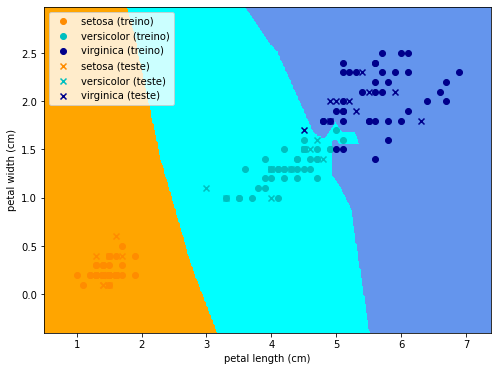

In [46]:
atributos = ['petal length (cm)', 'petal width (cm)']

df, X, y = obter_atributos(ds, atributos)

# X.values e y.values para extrai os dados como numpy arrays
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X.values, y.values, test_size=0.2, random_state=1,
    stratify=y.values)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_treino, y_treino) 
pred = knn.predict(X_teste)   # classificar as instâncias do conjunto de teste.

print("Acurácia no teste: %.2f" % accuracy_score(y_teste, pred))

plotar_fronteira_decisao(knn, X_treino, y_treino, X_teste, y_teste)
plt.show()

Note que ainda há uma pequena região na qual podemos ter confusão entre as classes *versicolor* e *virginica*. Entretanto esta confusão é bem menor que no espaço dos outros atributos, avaliado anteriormente.

A acurácia no conjunto de teste foi passou de 70 para 97%! Note como neste espaço de atributos a separação entre as 3 classes aconteceu de forma muito melhor. Isto mostra que é muito importante usarmos atributos que sejam **discriminativos**, ou seja, que contenham informações relevantes para a separar as classes.

Embora neste caso 2 atributos foram suficientes para praticamente resolver o problema, em outras situações podem ser necessários mais atributos para obter resultados satisfatórios. O algoritmo KNN também pode ser usado nestes casos. A seguir, usamos o KNN com os 4 atributos da base de dados iris para realizar as predições.

## KNN com 4 Atributos

In [47]:
X = ds.data #vamos usar todos os atributos
y = ds.target

# X.values e y.values para extrai os dados como numpy arrays
X_treino, X_teste, y_treino, y_teste = train_test_split(
        X.values, y.values, test_size=0.2, random_state=1,
        stratify=y.values)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_treino, y_treino) 
pred = knn.predict(X_teste)   # classificar as instâncias do conjunto de teste.

print("Acurácia no teste: %.2f" % accuracy_score(y_teste, pred))

Acurácia no teste: 0.97


No caso desta base de dados o resultado não melhorou mais quando usamos todos os atributos. Note que não é possível plotar diretamente os 4 atributos em um gráfico fácil de entender, como fizemos nos casos com 2 atributos. Para ter uma noção de um espaço com mais de 2 dimensões podemos usar PCA, como vimos na aula passada. Também podemos fazer a classificação no espaço de atributos gerado pelo PCA, onde cada componente principal serve como um atributo.

A abordagem de usar todos os atributos é razoavelmente comum. É importante lembrar que o KNN não funciona muito bem com muitos atributos. Por isso, é importante testar vários algoritmos de classificação. Ao longo do curso vamos estudar outros classificadores e como escolher qual classificador é melhor para determinado problema.

A seguir um exemplo de como classificar no espaço gerado pelo PCA.

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = ds.data #vamos usar todos os atributos
y = ds.target

# X.values e y.values para extrai os dados como numpy arrays
X_treino, X_teste, y_treino, y_teste = train_test_split(
        X.values, y.values, test_size=0.2, random_state=1,
        stratify=y.values)

# É necessário colocar todos os atributos na mesma escala 
# para que o PCA funcione corretamente.
ss = StandardScaler()
# os parametros da normalização são calculados apenas no conjunto de treino
ss.fit(X_treino) 
X_treino = ss.transform(X_treino) 
# os dados do conjunto de teste são normalizados de acordo com os parametros 
# estimados no conjunto de treino!
X_teste = ss.transform(X_teste) 

pca = PCA(n_components=2)
pca.fit(X_treino)
X_treino_pca = pca.transform(X_treino)
X_teste_pca = pca.transform(X_teste)

# X_treino_pca = np.hstack((X_treino_pca[:,0] * pca.explained_variance_ratio_[0], X_treino_pca[:,1] * pca.explained_variance_ratio_[1])).reshape((2, -1)).T
# X_teste_pca = np.hstack((X_teste_pca[:,0] * pca.explained_variance_ratio_[0], X_teste_pca[:,1] * pca.explained_variance_ratio_[1])).reshape((2, -1)).T

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_treino_pca, y_treino)  
# classificar as instâncias do conjunto de teste.
pred = knn.predict(X_teste_pca)  

print("Acurácia no teste: %.2f" % accuracy_score(y_teste, pred))

print("Variância explicada por PC: %s (total: %.3f)" % 
      (pca.explained_variance_ratio_,sum(pca.explained_variance_ratio_)))

print()

ax = plotar_fronteira_decisao(knn, X_treino_pca, y_treino, X_teste_pca, y_teste)
ax.set_xlabel('PC 0 (exp_var=%.2f)' % pca.explained_variance_ratio_[0])
ax.set_ylabel('PC 1 (exp_var=%.2f)' % pca.explained_variance_ratio_[1])
plt.show()

NameError: name 'ds' is not defined

Note que a acurácia no espaço gerado 2D pelo PCA foi inferior a acurácia obtida na classificação usando todos os 4 atributos. Isto é normal, uma vez que a projeção realizada pelo PCA "comprime" os dados para um espaço de menor dimensionalidade. 

Note que a variância explicada pelo PCA é de 96%, indicando que esta visualização consegue capturar bem a essência da distribuição do espaço na sua dimensionalidade original. Note também que a quantidade de variância explicada no eixo-x (PC 0) é aproximadamente três vezes a variância explicada no eixo-y (PC 1). A parametrização-padrão do KNN não considera esta diferença para realizar as predições.

# Efeito do valor de k

Até agora usamos *k=1* para realizar as predições. Entretanto, não há razão para acreditar que *k=1* seja a melhor escolha possível para este problema. A seguir vejamos o efeito de *k* na fronteira de decisão.

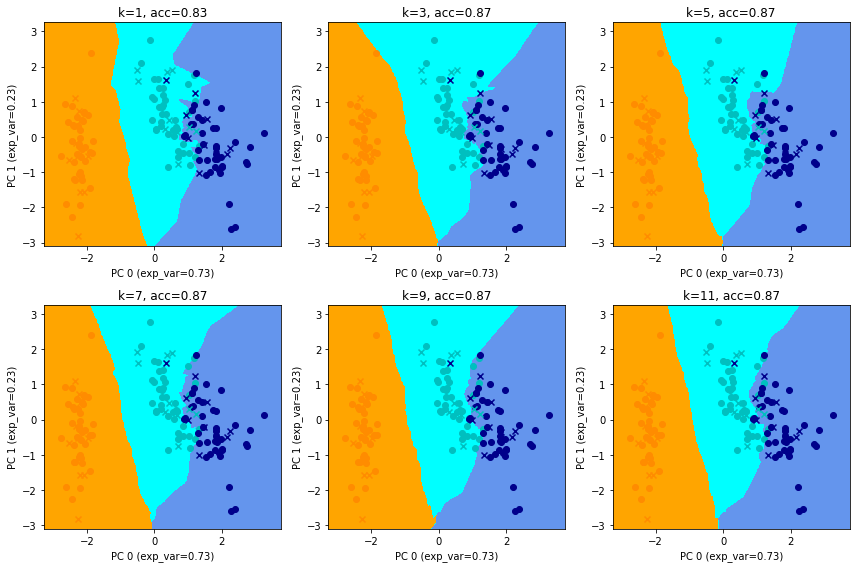

In [49]:
nrows = 2
ncols = 3
k = 1

X = ds.data #vamos usar todos os atributos
y = ds.target

X_treino, X_teste, y_treino, y_teste = train_test_split(
        X.values, y.values, test_size=0.2, random_state=1,
        stratify=y.values)

ss = StandardScaler()
ss.fit(X_treino)
X_treino = ss.transform(X_treino) 
X_teste = ss.transform(X_teste)

pca = PCA(n_components=2)
pca.fit(X_treino)
X_treino_pca = pca.transform(X_treino)
X_teste_pca = pca.transform(X_teste)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(12,8))

for row in range(nrows):
    for col in range(ncols):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino_pca, y_treino) 
        # classificar as instâncias do conjunto de teste.        
        pred = knn.predict(X_teste_pca)   

        plotar_fronteira_decisao(knn, X_treino_pca, y_treino, X_teste_pca, y_teste, 
                                 ax=axs[row][col])
        
        axs[row][col].get_legend().set_visible(False)
        axs[row][col].set_title('k=%d, acc=%.2f' % (k, accuracy_score(y_teste, pred)))
        
        axs[row][col].set_xlabel('PC 0 (exp_var=%.2f)' % pca.explained_variance_ratio_[0])
        axs[row][col].set_ylabel('PC 1 (exp_var=%.2f)' % pca.explained_variance_ratio_[1])
        
        k+=2

fig.tight_layout()




Conforme *k* aumenta, verificamos que há uma *"suavização"* da fronteira de decisão. Esta suaviação é um tipo de **regularização**. Note que houve melhora na acurácia no conjunto de teste com *k>1* quando comparamos com o modelo gerado com *k=1*. Entretanto esse nem sempre é o caso. Dependendo dos dados e do espaço de atributos, o valor ótimo de *k* varia bastante. *k* é conhecido como um **hiperparâmetro** do KNN. Um hiperparâmetro de um algoritmo de aprendizagem de máquina é um parâmetro que é usado para controlar o funcionamento do algoritmo. Em comparação, os demais parâmetros do modelo, como por exemplo o limar do classificador baseado em limiar), são aprendidos a partir dos dados.

Como escolher o melhor valor para *k*? Vamos estudar isso na próxima aula!

<!-- %chamamos k de um *hiperparametro* para o knn -->
<!-- # como escolher o melhor valor para k?? -->